In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pylab as pl
from torch.nn import Parameter

In [40]:
# Generatorの定義
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*4),  # RGBA画像のサイズに合わせる
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 4, 64, 64)  # RGBA画像の形式に変換
        return img

In [41]:
# Discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64*64*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [42]:
class RGBADataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGBA")
        if self.transform:
            image = self.transform(image)
        return image

In [43]:
# データセットの読み込み
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = RGBADataset(root="SkinData/data/alex/", transform=transform)
print(len(dataset))

42


[Epoch 9/10] [Batch 1/3] [D loss: 0.09200656414031982] [G loss: 2.770547389984131]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 2/3] [D loss: 0.13846455514431] [G loss: 1.8325068950653076]

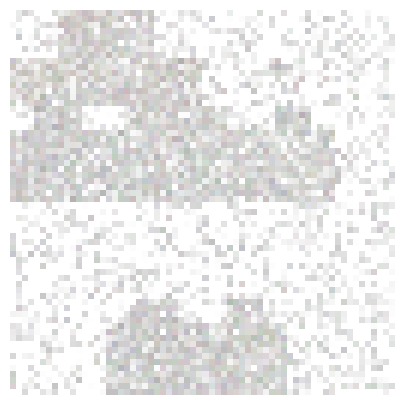

In [44]:
# ハイパーパラメータ
latent_dim = 10
lr = 0.0003
batch_size = 20
n_epochs = 10

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# モデルの初期化
generator = Generator(latent_dim)
discriminator = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# 損失関数と最適化手法の定義
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

images = np.array([])
# 学習ループ
for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.to(device)
        # Generatorの学習
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), torch.ones(batch_size, 1).to(device))
        g_loss.backward()
        optimizer_G.step()

        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(gen_imgs.size(0), 1).to(device)

        # Discriminatorの学習
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        print(f"\r[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]",end="")

z = torch.randn(25, latent_dim)
gen_imgs = generator(z)
gen_imgs = gen_imgs.view(gen_imgs.size(0), 4, 64, 64)
plt.figure(figsize=(5, 5))
plt.imshow(gen_imgs[gen_imgs.size(0)-1].cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')

dir_path = "Created_Skin/"
files = os.listdir(dir_path)
img = cv2.cvtColor(gen_imgs[gen_imgs.size(0)-1].cpu().detach().numpy().transpose(1, 2, 0)*255, cv2.COLOR_RGB2BGRA)
cv2.imwrite(f"{dir_path}ai_{len(files)+1}.png", img)
plt.show()

In [45]:
# z = torch.randn(25, latent_dim)
# gen_imgs = generator(z)
# gen_imgs = gen_imgs.view(gen_imgs.size(0), 4, 64, 64)
# plt.figure(figsize=(200, 200))
# for k in range(gen_imgs.size(0)):
#     plt.subplot(25, 1, k+1)
#     plt.imshow(gen_imgs[k].cpu().detach().numpy().transpose(1, 2, 0))
#     plt.axis('off')
# plt.show()

In [46]:
def display_process(hist, G, image_frame_dim, sample_z_, fix=True):
    plt.gcf().clear()

    fig = plt.figure(figsize=(24, 15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    ax1 = fig.add_subplot(1, 2, 1)

    ax1.plot(x, y1, label='D_loss')
    ax1.plot(x, y2, label='G_loss')

    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Loss')

    ax1.legend(loc=4)
    ax1.grid(True)

    samples = G(sample_z_)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2

    for i in range(image_frame_dim*image_frame_dim):
        ax = fig.add_subplot(image_frame_dim, image_frame_dim*2, (int(i/image_frame_dim)+1)*image_frame_dim+i+1, xticks=[], yticks=[])
        if samples[i].shape[2]==3:
            ax.imshow(samples[i])
        else:
            ax.imshow(samples[i][:, :, 0], cmap='gray')

In [47]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            # vベクトルの更新
            # https://pytorch.org/docs/stable/generated/torch.mv.html
            v.data = self._l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            # uベクトルの更新
            u.data = self._l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        # レイヤーのWをW_SNに置き換える
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        # Conv2dのweight matrixは4次元
        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        # new()で同じdtypeの新しいTensorを作り，normal_(mean, std)で初期化
        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False) # ( h, )
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False) # ( w, )
        u.data = self._l2normalize(u.data)
        v.data = self._l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def _l2normalize(self, v, eps=1e-12):
        return v / (v.norm() + eps)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [48]:
class sngan_discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(sngan_discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            SpectralNorm(nn.Conv2d(self.input_dim, 64, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 64, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 128, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 128, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 256, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
            SpectralNorm(nn.Linear(256 * (self.input_size//4) * (self.input_size//4), self.output_dim)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, 256 * (self.input_size//4) * (self.input_size//4)))

        return x

In [49]:
# Xavierの初期化, Heの初期化など採用するネットワーク構造, 活性化関数に合わせた初期化手法は多数
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [50]:
class generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

In [74]:
class SNGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 3
        self.sample_num = 20
        self.batch_size = 2
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset # mnist, fashion-mnist, cifar10

        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])
        dataset = RGBADataset(root="SkinData/data/alex/", transform=transform)
        self.data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = sngan_discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G
        self.D
        self.BCE_loss = nn.BCELoss()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_, self.y_fake_

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, x_ in enumerate(self.data_loader):
                # if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    # break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_, z_

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                print(iter)
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()

        plt.close()
        print("Training finish!")

In [75]:
sngan = SNGAN()  # 他のデータセットで学習する場合: SNGAN(dataset='fashion-mnist'), SNGAN(dataset='cifar10'
sngan.train()

RuntimeError: Given groups=1, weight of size [64, 64, 3, 3], expected input[2, 4, 64, 64] to have 64 channels, but got 4 channels instead